# Part of Speech Tagger (FeedForward, RNN & Transformers comparison)
In this notebook we train three Neural Networks models for Part of Speech (POS) task. 

Firstly, we use unsupervised pre-trained word embeddings (vector representation of words) of GloVe-WiKi 50D and UD_English-GUM Dataset contained train, validation & test examples of sentences and POS tag per word. The UD_English-GUM dataset includes english sentences with part of speech tag for every word In our work we tokenize the words creating tokenized sentences as input for the model and one hot representation of any POS tag as model target.

Secondly, we create two types of Dataset Objects for sequential and non-sequential data. The sequential dataset is a 3 dimensional tensor, splitted at batches of 128 batch size, with 2nd and 3rd dimension are corresponded on max sentence length and embedding vector size. Equivalent at non-sequential dataset is a 2 dimensional vector, splitted at batches of 128 batch size, with 2nd dimension is corresponded on embedding vector size, summing up the word embeddings giving a slide window on a sentence.

We create a Feed Forward based neural network model for non-sequential dataset, a Recurrent Neural Network based model and a Transformer based model for sequential dataset. At this work we split the datasets on train, validation and test examples, we train the models using F1 score and tag (or class weighted) cross entropy loss function, because of the number labels per POS tag are unbalanced (we apply class weighted cross entropy only at sequential labels and keeping the non-sequential labels as non weighted). Also we use validation examples for early stoping patience strategy, following a number of last epoch measures and if measure is not droped, giving and delta lower bound, then the training process stops. At this work we follow the last 10 epoch measures, uses the F1 validation score as measure and gives the 0.001 as delta lower bound.


Finally we show measures to compare the trained models at test examples, using Recall/Precision curve with the Area Under the Curve (AUC), history of F1 score and history of class weighted cross entropy loss (or cost). Furthermore we give some dummy sentence examples and how th models predict the POS tags.

# Additional Packages & Dataset downloading

In [ ]:
!pip install conllu
!pip install tensorflow_datasets
!pip install gensim

In [ ]:
!wget https://github.com/UniversalDependencies/UD_English-GUM/archive/master.zip
!unzip master.zip

# Import Packages

In [1]:
from algomorphism.model.base import LossBase, BaseNeuralNetwork, MetricBase
from algomorphism.figure.opt import multiple_models_history_figure
from algomorphism.model.losses import ClassWeightedCategoricalCrossEntropy as ClassWeightedCategoricalCrossEntropyLoss
from algomorphism.model.metrics import ClassWeightedCategoricalCrossEntropy as ClassWeightedCategoricalCrossEntropyMetric
from algomorphism.model.metrics import CategoricalF1Score
from algomorphism.model.layers import FullConnected, MultiHeadAttention

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, PReLU, BatchNormalization, Input, LayerNormalization
from tensorflow.keras.layers import Embedding, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
from sklearn.preprocessing import LabelBinarizer

from conllu import parse_incr
import gensim.downloader as api
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
# Optional GPU usage

# for gpu in tf.config.list_physical_devices('GPU'):
#     print(gpu)
#     tf.config.experimental.set_memory_growth(gpu, True)


# Set up

## Datasets

### Non-Sequential Dataset

In [3]:
class NonSequentialDataset(object):
  """
  Non Sequential POS Dataset for Feed Forward Model.
  """
  def __init__(self, word2vec_model, window=1):
    self.word2vec_model = word2vec_model
    self.__w = window

  def set_data_from_files(self, train_path, val_path, test_path):
    file_trn = open(train_path)
    self.__x_train, tags_train, self.__vocab = self.__window_word2vec_and_tags_training(file_trn)

    file_val = open(val_path)
    self.__x_val, tags_val = self.__window_word2vec_and_tags_val_test(file_val)

    file_test = open(test_path)
    self.__x_test, tags_test = self.__window_word2vec_and_tags_val_test(file_test)


    self.__lb = LabelBinarizer()
    tag_classes = list(set(tags_train))
    self.__lb.fit(tag_classes)

    self.__y_train = self.__lb.transform(tags_train)
    self.__y_val = self.__lb.transform(tags_val)
    self.__y_test = self.__lb.transform(tags_test)

    self.train = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_train, tf.float32),
        tf.cast(self.__y_train, tf.float32)
    )).batch(128)

    self.val = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_val, tf.float32),
        tf.cast(self.__y_val, tf.float32)
    )).batch(128)

    self.test = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_test, tf.float32),
        tf.cast(self.__y_test, tf.float32)
    )).batch(128)

  def __plus_operator_sliding_window(self, words2vecs):
    if self.__w == 1:
      return words2vecs

    words2vecs = np.array(words2vecs)
    N = words2vecs.shape[0]
    words2vecs = np.concatenate((np.zeros(((self.__w-1)//2, words2vecs.shape[1])),
                                words2vecs,
                                np.zeros(((self.__w-1)//2, words2vecs.shape[1]))
                                ),axis=0)
    sent_embedings = []
    for i in range(0, N):
      sent_embedings.append(
          words2vecs[i:i+self.__w].sum(axis=0)
      )
    return sent_embedings

  # this is useful for preprocess train, val, test data
  def __window_word2vec_and_tags_training(self, file):
    window_embedings = []
    tags = []
    vocab = set()
    for sent in parse_incr(file):
      words2vecs = []
      for word in sent:
        try:
          words2vecs.append(self.word2vec_model[word['form']])
          tags.append(word['upostag'])
          vocab.add(word['form'])
        except Exception as e:
          pass

      if len(words2vecs) != 0:
        window_embedings+= self.__plus_operator_sliding_window(words2vecs)

    window_embedings = np.array(window_embedings)
    return window_embedings, tags, vocab

  def __window_word2vec_and_tags_val_test(self, file):
    window_embedings = []
    tags = []
    for sent in parse_incr(file):
      words2vecs = []
      for word in sent:
        try:
          if word['form'] in self.__vocab:
            words2vecs.append(self.word2vec_model[word['form']])
          else:
            var = self.word2vec_model[word['form']]
            words2vecs.append(np.zeros(self.word2vec_model.vector_size,))
          tags.append(word['upostag'])
        except Exception as e:
          pass

      if len(words2vecs) != 0:
        window_embedings+= self.__plus_operator_sliding_window(words2vecs)

    window_embedings = np.array(window_embedings)
    return window_embedings, tags

  def window_word2vec_sentece(self,sentence):
    words2vecs = []
    listtag = []
    for word in sentence.split():
      try:
        if word in self.__vocab:
          words2vecs.append(self.word2vec_model[word])
        else:
          words2vecs.append(np.zeros(self.word2vec_model.vector_size,))
        listtag.append([word, ''])
      except Exception as e:
        listtag.append([word, None])

    if len(words2vecs) != 0:
      sent_embedings = self.__plus_operator_sliding_window(words2vecs)
    else:
      return None, listtag

    sent_embedings = np.array(sent_embedings)
    return sent_embedings, listtag

  def get_numpy_dataset(self):
    return self.__x_train, self.__y_train, self.__x_val, self.__y_val, self.__x_test, self.__y_test

  def get_numpy2tag(self, y_, onehot=False):
    if onehot:
      y_ = np.array(y_).argmax(axis=1)
    return self.__lb.classes_[y_]

  def get_tags_names(self):
    return self.__lb.classes_

### Sequential Dataset

In [4]:
class SequentialDataset(object):
  """
  POS Dataset object for RNN and Transformer models.
  """
  def __init__(self, word2vec_model):
    self.word2vec_model = word2vec_model

  def get_numpy_dataset(self):
    return self.__x_train, self.__y_train, self.__x_val, self.__y_val, self.__x_test, self.__y_test

  def __pad_sequence(self, sequence_sent, sequence_tag):
    x = pad_sequences(sequence_sent, maxlen=self.__max_length_sent, padding='post', value=self.sents_encode(['__PAD__'])[0][0])
    sequence_tag = pad_sequences(sequence_tag, maxlen=self.__max_length_sent, padding='post', value=self.tags_encode(['__PAD__'])[0][0])
    y = np.array([self.__lb.transform([int(tag) for tag in list(sequence)]) for sequence in list(sequence_tag)])
    return x, y

  def tag_decode(self, seqquence_tag):
    tag_dec = []
    for seq in seqquence_tag:
      tag_dec.append(self.__tags_encoder.decode(seq))
    return tag_dec

  def sent_decode(self, sequence_sent):
    sents_dec = self.__text_encoder.sequences_to_texts(sequence_sent)
    return sents_dec

  def tags_encode(self, tags):
    tag_enc = []
    for tag in tags:
      tag_enc.append(self.__tags_encoder.encode(tag))
    return tag_enc

  def sents_encode(self, sents):
    sents_enc = self.__text_encoder.texts_to_sequences(sents)
    return sents_enc

  def __set_up_data_from_train_file(self, file_path):
    vocab = set()
    sents = []
    tags = []
    tags_set = set()
    file_obj = open(file_path)
    max_length_sent = 0
    for sent in parse_incr(file_obj):
      tags.append('')
      sents.append('')
      if len(sent) > max_length_sent:
        max_length_sent = len(sent)
      for w in sent:
        try:
          # check if word exist on word emb
          word = str.lower(w['form'])
          var = self.word2vec_model[word]
          sents[-1]+= ' '+str(word)
          vocab.add(str(word))
        except Exception as e:
          # remove the word that doesnt contain in word2vec_model
          sents[-1] += ' '+'__OOV__'
          vocab.add('__OOV__')

        tags[-1] +=  ' '+w['upostag']
        tags_set.add(w['upostag'])


    self.__max_length_sent = max_length_sent
    tags_set.add('__PAD__')
    vocab.add('__PAD__')

    self.__vocab_size = len(vocab)+1
    self.__tags_size = len(tags_set)

    # we experimented with two tf Tokenizers(encoders or more simply coders) tf.keras and tfds Tokenizer(for big corpus)
    self.__text_encoder = tf.keras.preprocessing.text.Tokenizer(self.__vocab_size, oov_token='__UNK__', filters='', lower=False)
    self.__text_encoder.fit_on_texts([' '.join(list(vocab))])
    self.__tags_encoder = tfds.deprecated.text.TokenTextEncoder(
      list(tags_set),
      tokenizer=tfds.deprecated.text.Tokenizer(
        alphanum_only=True
      )
    )

    embedding_dim = self.word2vec_model.vector_size
    embedding_matrix = np.zeros((self.__vocab_size, embedding_dim))
    for word in vocab:
      index = self.sents_encode([word])[0][0]
      try:
        embedding_matrix[index] = self.word2vec_model[word]
      except:
        pass

    self.__embedding_matrix = embedding_matrix
    self.__lb = LabelBinarizer()

    tags_code = [int(tag) for tag in self.__tags_encoder.encode(' '.join(list(tags_set)))]
    self.__lb.fit(tags_code)
    sequence_sent = self.sents_encode(sents)


    sequence_tag = self.tags_encode(tags)
    x_train, y_train = self.__pad_sequence(sequence_sent, sequence_tag)
    return x_train, y_train


  def __set_up_data_from_val_or_test_file(self, file_path):
    sents = []
    tags = []
    file_obj = open(file_path)
    for sent in parse_incr(file_obj):
      tags.append('')
      sents.append('')
      for w in sent:
        try:
          word = str.lower(w['form'])
          var = self.word2vec_model[word]
          sents[-1]+= ' '+word
        except Exception as e:
          # remove the word that doesnt contain in word2vec_model
          sents[-1] += ' '+'__OOV__'
        tags[-1] +=  ' '+w['upostag']

    sequence_sent = self.sents_encode(sents)
    sequence_tag = self.tags_encode(tags)
    x, y = self.__pad_sequence(sequence_sent, sequence_tag)
    return x, y

  def set_data_from_files(self,train_path, val_path, test_path):

    self.__x_train, self.__y_train = self.__set_up_data_from_train_file(train_path)

    self.train = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_train, tf.int32),
        tf.cast(self.__y_train, tf.float32)
    )).batch(128)

    self.__x_val, self.__y_val = self.__set_up_data_from_val_or_test_file(val_path)
    self.__x_test, self.__y_test = self.__set_up_data_from_val_or_test_file(test_path)

    self.val = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_val, tf.int32),
        tf.cast(self.__y_val, tf.float32)
    )).batch(128)

    self.test = tf.data.Dataset.from_tensor_slices((
        tf.cast(self.__x_test, tf.int32),
        tf.cast(self.__y_test, tf.float32)
    )).batch(128)

  def get_max_length_sent(self):
    return self.__max_length_sent

  def get_vocab_size(self):
    return self.__vocab_size

  def get_tags_size(self):
    return self.__tags_size

  def get_embedding_matrix(self):
    return self.__embedding_matrix

## Neural Network Models

### Feed Forward Model

In [5]:
class FeedForward(tf.keras.Model, BaseNeuralNetwork):
  def __init__(self, dataset, x_dim, n_class, optimizer=None, clip_norm=0.0, early_stop_vars=None):
    tf.keras.Model.__init__(self, name='ff')
    status = [
      [0],
      [1, 2]
    ]

    self.score_mtr = MetricBase(self,
                                [CategoricalF1Score()],
                                status,
                                [0]
                              )

    self.cost_mtr = MetricBase(self,
                                [tf.keras.metrics.CategoricalCrossentropy()],
                                status,
                                [0],
                                1
                              )

    self.cost_loss = LossBase(self,
                              [tf.keras.losses.CategoricalCrossentropy()],
                              status,
                              [0]
                            )

    BaseNeuralNetwork.__init__(self, status, dataset=dataset, optimizer=optimizer,
                               clip_norm=clip_norm, early_stop_vars=early_stop_vars)

    self.n_class = n_class
    self.x_dim = x_dim

    self.Input = Input(self.x_dim)

    self.fc1 = FullConnected(x_dim[-1],128, name='fc1')
    self.batchnorm1 = BatchNormalization(name='batchnorm1')
    self.prelu1 =  PReLU(name='prelu1')
    self.drop1 = Dropout(0.25, name='drop1')

    self.fc2 = FullConnected(128, 256, name='fc2')
    self.batchnorm2 = BatchNormalization(name='batchnorm2')
    self.prelu2 =  PReLU(name='prelu2')
    self.drop2 = Dropout(0.3, name='drop2')

    self.fc3 = FullConnected(256, 512, name='fc3')
    self.batchnorm3 = BatchNormalization(name='batchnorm3')
    self.prelu3 =  PReLU(name='prelu3')
    self.drop3 = Dropout(0.35, name='drop3')

    self.softmax = FullConnected(512, self.n_class, activation="softmax")

  def call(self, inputs):

    x = self.fc1(inputs[0])
    x = self.batchnorm1(x)
    x = self.prelu1(x)
    x = self.drop1(x)

    x = self.fc2(x)
    x = self.batchnorm2(x)
    x = self.prelu2(x)
    x = self.drop2(x)

    x = self.fc3(x)
    x = self.batchnorm3(x)
    x = self.prelu3(x)
    x = self.drop3(x)

    y = self.softmax(x)

    return tuple((y,))

### RNN model

In [6]:
class RNN(tf.keras.Model, BaseNeuralNetwork):

  def __init__(self, max_length_sent, vocab_size, n_class, embedding_matrix, dataset, class_weights, optimizer=None,
               clip_norm=0.0, early_stop_vars=None):

    tf.keras.Model.__init__(self, name='rnn')
    status = [
          [0],
          [1, 2]
        ]

    self.score_mtr = MetricBase(self,
                                [CategoricalF1Score()],
                                status,
                                [0]
                              )

    self.cost_mtr = MetricBase(self,
                               [ClassWeightedCategoricalCrossEntropyMetric(class_weights)],
                               status,
                               [0],
                               1
                              )

    self.cost_loss = LossBase(self,
                              [ClassWeightedCategoricalCrossEntropyLoss(class_weights)],
                              status,
                              [0]
                            )

    BaseNeuralNetwork.__init__(self, status, dataset=dataset,
                           optimizer=optimizer,
                           clip_norm=clip_norm,
                           early_stop_vars=early_stop_vars)

    self.Input = Input((max_length_sent,))
    self.embedding = Embedding(vocab_size, embedding_matrix.shape[1],
      mask_zero=True, trainable=True, weights=[embedding_matrix])

    self.lstm = LSTM(512, return_sequences=True, name='lstm', activation='tanh')
    self.bidirectional = Bidirectional(self.lstm, name='bidirectional')
    self.timedistributed = TimeDistributed(Dense(n_class, 'softmax'))

  def call(self, inputs):
    x = self.embedding(inputs[0])
    x = self.bidirectional(x)
    y = self.timedistributed(x)

    return tuple((y,))

### Transformer Model

In [7]:
class PassionalEncoding(tf.Module):
    def __init__(self, max_length, dim_embedding):
        self.__sequence =  self.__generate_sequence(max_length, dim_embedding)
    
    def __generate_sequence(self, max_length, dim_embedding):
        sequence = []
        for pos in range(max_length):
            vector = []
            i = 0
            k = 0
            while True:
                el = pos/tf.pow(1e+4,2*i/dim_embedding)
                els = tf.math.sin(el)
                vector.append(els)
                k += 1
                if k > dim_embedding - 1:
                    break
                elc = tf.math.cos(el)
                vector.append(elc)
                i += 1
                k += 1
                if k > dim_embedding - 1:
                    break
            sequence.append(vector)
        sequence = tf.cast(sequence, tf.float32)
        return sequence
    
    def __call__(self):
        return self.__sequence

class TransformerModule(tf.Module):
    def __init__(self, feature_dim, attention_dims, n_heads=8, name='transformer_module'):
        super(TransformerModule, self).__init__(name=name)

        self.mha = MultiHeadAttention(feature_dim, attention_dims, n_heads)
        self.ln0 = LayerNormalization(axis=-1)
        self.fc0 = FullConnected(feature_dim, 1024, activation='relu')
        self.fc1 = FullConnected(1024, feature_dim)
        self.ln1 = LayerNormalization(axis=-1)
    
    def __call__(self, q, k, v):
        y = self.mha(q, k, v)
        y = y + v
        y = self.ln0(y)
        y1 = self.fc0(y)
        y1 = self.fc1(y1)
        y = y1 + y
        y = self.ln1(y)
        return y

class TransformerModel(tf.keras.Model, BaseNeuralNetwork):
    def __init__(self, max_length_sent, vocab_size, n_class, embedding_matrix, dataset, class_weights, optimizer=None,
               clip_norm=0.0, early_stop_vars=None):
        tf.keras.Model.__init__(self, name='transformer_model')

        status = [
            [0],
            [1, 2]
        ]       

        self.score_mtr = MetricBase(self,
                            [CategoricalF1Score()],
                            status,
                            [0]
                            )

        self.cost_mtr = MetricBase(self,
                                [ClassWeightedCategoricalCrossEntropyMetric(class_weights)],
                                status,
                                [0],
                                1
                                )

        self.cost_loss = LossBase(self,
                                [ClassWeightedCategoricalCrossEntropyLoss(class_weights)],
                                status,
                                [0]
                                )

        BaseNeuralNetwork.__init__(self, status, dataset=dataset,
                           optimizer=optimizer,
                           clip_norm=clip_norm,
                           early_stop_vars=early_stop_vars)

        

        self.Input = Input((max_length_sent,))

        feature_dim = embedding_matrix.shape[1]

        self.embedding = Embedding(vocab_size, feature_dim,
            mask_zero=True, trainable=True, weights=[embedding_matrix])
        
        self.positional_emb = PassionalEncoding(max_length_sent, feature_dim)

        attention_dims = [64, 64]
        for i in range(3):
            tmi = TransformerModule(feature_dim, attention_dims, n_heads=2)
            setattr(self, 'tm{}'.format(i), tmi)

        self.out = Dense(n_class, 'softmax')
    
    def call(self, inputs):
        x = self.embedding(inputs[0])
        pos_e = self.positional_emb()
        y = pos_e + x
        
        for i in range(3):
            tmi = getattr(self, 'tm{}'.format(i))
            y = tmi(y, y, y)

        y = self.out(y)

        return tuple((y,))

# Load

## Load Glove embeddings

In [8]:
word2vec_model = api.load('glove-wiki-gigaword-50')

## Load Examples

In [9]:
pos_nonseq = NonSequentialDataset(word2vec_model, 3)
pos_seq = SequentialDataset(word2vec_model)

train_path = 'UD_English-GUM-master/en_gum-ud-train.conllu'
test_path = 'UD_English-GUM-master/en_gum-ud-test.conllu'
val_path = 'UD_English-GUM-master/en_gum-ud-dev.conllu'

pos_nonseq.set_data_from_files(train_path, val_path, test_path)
pos_seq.set_data_from_files(train_path, val_path, test_path)

## Early stopping and class weights computation

In [10]:
early_stop_vars = {
  'es_strategy':'patience',
  'es_metric':'val_score',
  'es_min_delta': 1e-3,
  'es_patience': 10
}

y_train_rnn = pos_seq.get_numpy_dataset()[1]
y_train_rnn = y_train_rnn.reshape(y_train_rnn.shape[0]*y_train_rnn.shape[1], y_train_rnn.shape[2]).astype(np.float32)
class_weights = tf.reduce_mean(y_train_rnn, axis=0)
class_weights = 1 - tf.cast(class_weights, tf.float32)

# Train

## Feed Forward

In [11]:
opt_ff = Adam(learning_rate=1e-4)
ff = FeedForward(dataset=pos_nonseq,
                 x_dim=pos_nonseq.get_numpy_dataset()[0].shape[1:],
                 n_class=len(pos_nonseq.get_tags_names()),
                 optimizer=opt_ff,
                 clip_norm=0.1,
                 early_stop_vars=early_stop_vars)

In [12]:
ff.train(pos_nonseq, 100, print_types=['train', 'val', 'test'])

Epoch 1 finished
train cost: 1.7207931280136108
train score: 0.5613484382629395
val cost: 1.7466232776641846
val score: 0.5431448221206665
test cost: 1.7501972913742065
test score: 0.5478057861328125
Epoch 2 finished
train cost: 1.6147005558013916
train score: 0.5901830196380615
val cost: 1.6646604537963867
val score: 0.5660773515701294
test cost: 1.666061520576477
test score: 0.5699313282966614
Epoch 3 finished
train cost: 1.5548917055130005
train score: 0.6089054346084595
val cost: 1.6213798522949219
val score: 0.58207106590271
test cost: 1.622890830039978
test score: 0.583751916885376
Epoch 4 finished
train cost: 1.5153013467788696
train score: 0.6193339228630066
val cost: 1.5907504558563232
val score: 0.5894351005554199
test cost: 1.592133641242981
test score: 0.5927448272705078
Epoch 5 finished
train cost: 1.483487606048584
train score: 0.6283202767372131
val cost: 1.5656102895736694
val score: 0.599128246307373
test cost: 1.5666099786758423
test score: 0.5992632508277893
Epoch 6 

## RNN

In [13]:
opt_rnn = Adam(learning_rate=1e-4)
rnn = RNN(pos_seq.get_max_length_sent(),
          pos_seq.get_vocab_size(),
          pos_seq.get_tags_size(),
          pos_seq.get_embedding_matrix(),
          dataset=pos_seq,
          class_weights=class_weights,
          optimizer=opt_rnn,
          clip_norm=0.1,
          early_stop_vars=early_stop_vars)

In [14]:
rnn.train(pos_seq, 100, print_types=['train', 'val', 'test'])

Epoch 1 finished
train cost: 0.38663551211357117
train score: 0.9312999844551086
val cost: 0.388401061296463
val score: 0.9306876063346863
test cost: 0.40227043628692627
test score: 0.9287704825401306
Epoch 2 finished
train cost: 0.34727874398231506
train score: 0.9425268173217773
val cost: 0.35278865694999695
val score: 0.9415534138679504
test cost: 0.3652980327606201
test score: 0.9395840167999268
Epoch 3 finished
train cost: 0.3070339262485504
train score: 0.9532043933868408
val cost: 0.31318846344947815
val score: 0.95240318775177
test cost: 0.32567885518074036
test score: 0.9504026770591736
Epoch 4 finished
train cost: 0.2629525363445282
train score: 0.9610570669174194
val cost: 0.2694089412689209
val score: 0.9602870941162109
test cost: 0.28267666697502136
test score: 0.9582621455192566
Epoch 5 finished
train cost: 0.2208646982908249
train score: 0.9663942456245422
val cost: 0.22690610587596893
val score: 0.9654297232627869
test cost: 0.2402370125055313
test score: 0.963564872741

## Transformer

In [15]:
opt_rnn = tf.keras.optimizers.Adam(learning_rate=1e-4)
trf = TransformerModel(pos_seq.get_max_length_sent(),
          pos_seq.get_vocab_size(),
          pos_seq.get_tags_size(),
          pos_seq.get_embedding_matrix(),
          dataset=pos_seq,
          class_weights=class_weights,
          optimizer=opt_rnn,
          clip_norm=0.1,
          early_stop_vars=early_stop_vars)

In [16]:
trf.train(pos_seq, 100, print_types=['train', 'val', 'test'])

Epoch 1 finished
train cost: 0.3718411326408386
train score: 0.934561550617218
val cost: 0.37897658348083496
val score: 0.9337570667266846
test cost: 0.3909435272216797
test score: 0.9324960708618164
Epoch 2 finished
train cost: 0.2625782787799835
train score: 0.9583508968353271
val cost: 0.2758672833442688
val score: 0.9567826390266418
test cost: 0.2876979410648346
test score: 0.9556477665901184
Epoch 3 finished
train cost: 0.19216662645339966
train score: 0.9691039323806763
val cost: 0.2027677297592163
val score: 0.9674287438392639
test cost: 0.2144356518983841
test score: 0.9662495851516724
Epoch 4 finished
train cost: 0.155082106590271
train score: 0.9747180938720703
val cost: 0.16603663563728333
val score: 0.9729886651039124
test cost: 0.1788221150636673
test score: 0.9710309505462646
Epoch 5 finished
train cost: 0.13540542125701904
train score: 0.9776522517204285
val cost: 0.14633117616176605
val score: 0.9756436944007874
test cost: 0.15990887582302094
test score: 0.9738731384277

# Test Measures

## Precision/Recall- AUC

In [17]:
class PrecisionRecallCurve(tf.keras.metrics.Metric):
  def __init__(self,thresholds=None):
    super(PrecisionRecallCurve, self).__init__(name='prc')
    self.__precision = tf.keras.metrics.Precision(thresholds=thresholds)
    self.__recall = tf.keras.metrics.Recall(thresholds=thresholds)

  @tf.autograph.experimental.do_not_convert
  def update_state(self, y_true, y_pred):
    self.__precision.update_state(y_true, y_pred)
    self.__recall.update_state(y_true, y_pred)

  @tf.autograph.experimental.do_not_convert
  def result(self):
    precision = self.__precision.result().numpy()
    recall = self.__recall.result().numpy()

    precision = self.__fix_precision(precision)
    auc = np.sum((precision[1:] - precision[:-1])*recall[:-1])
    return auc

  def get_precision(self):
    precision = self.__precision.result().numpy()
    precision = self.__fix_precision(precision)
    return precision

  def get_recall(self):
    return self.__recall.result().numpy()

  def reset_states(self):
    self.__precision.reset_state()
    self.__recall.reset_state()

  def __fix_precision(self, precision):
    argmax_precision = precision.argmax()
    precision[argmax_precision:] = 1.0
    return precision

Text(0.5, 1.0, 'Test auc per model')

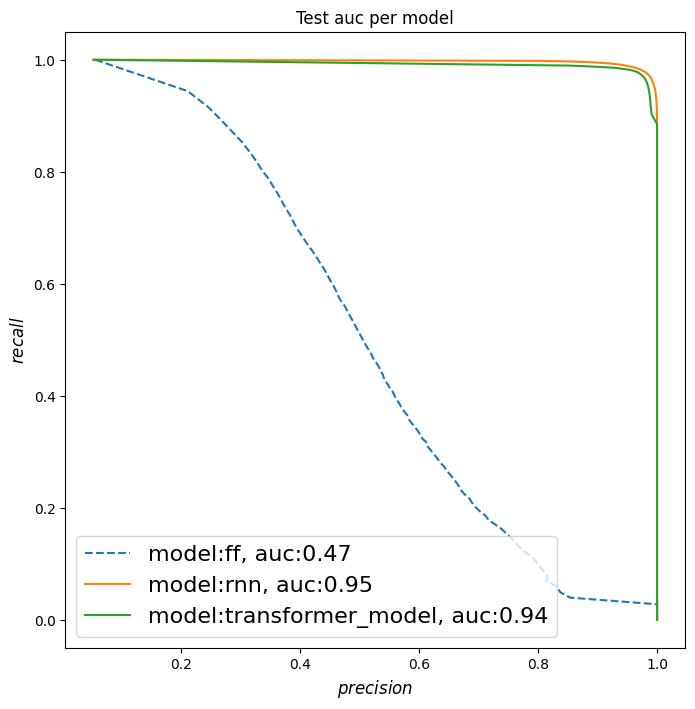

In [18]:
plt.figure(figsize=(8,8))
label_base = 'model:{}, auc:{:.2f}'
prc = PrecisionRecallCurve(np.linspace(0,1,100).tolist())

for x, y_true in pos_nonseq.test:
  y_pred = ff([x])[0]
  prc.update_state(y_true, y_pred)
auc = prc.result()
precision = prc.get_precision()
recall = prc.get_recall()
plt.plot(precision, recall,'--', label=label_base.format(ff.name, auc))

prc.reset_states()

for x, y_true in pos_seq.test:
  y_pred = rnn([x])[0]
  prc.update_state(y_true, y_pred)
auc = prc.result()
precision = prc.get_precision()
recall = prc.get_recall()
plt.plot(precision, recall, label=label_base.format(rnn.name, auc))

prc.reset_states()

for x, y_true in pos_seq.test:
  y_pred = trf([x])[0]
  prc.update_state(y_true, y_pred)
auc = prc.result()
precision = prc.get_precision()
recall = prc.get_recall()
plt.plot(precision, recall, label=label_base.format(trf.name, auc))

plt.legend(fontsize=16, loc='lower left')
plt.xlabel(r"$precision$", fontsize=12)
plt.ylabel(r"$recall$", fontsize=12)
plt.title("Test auc per model")

## History

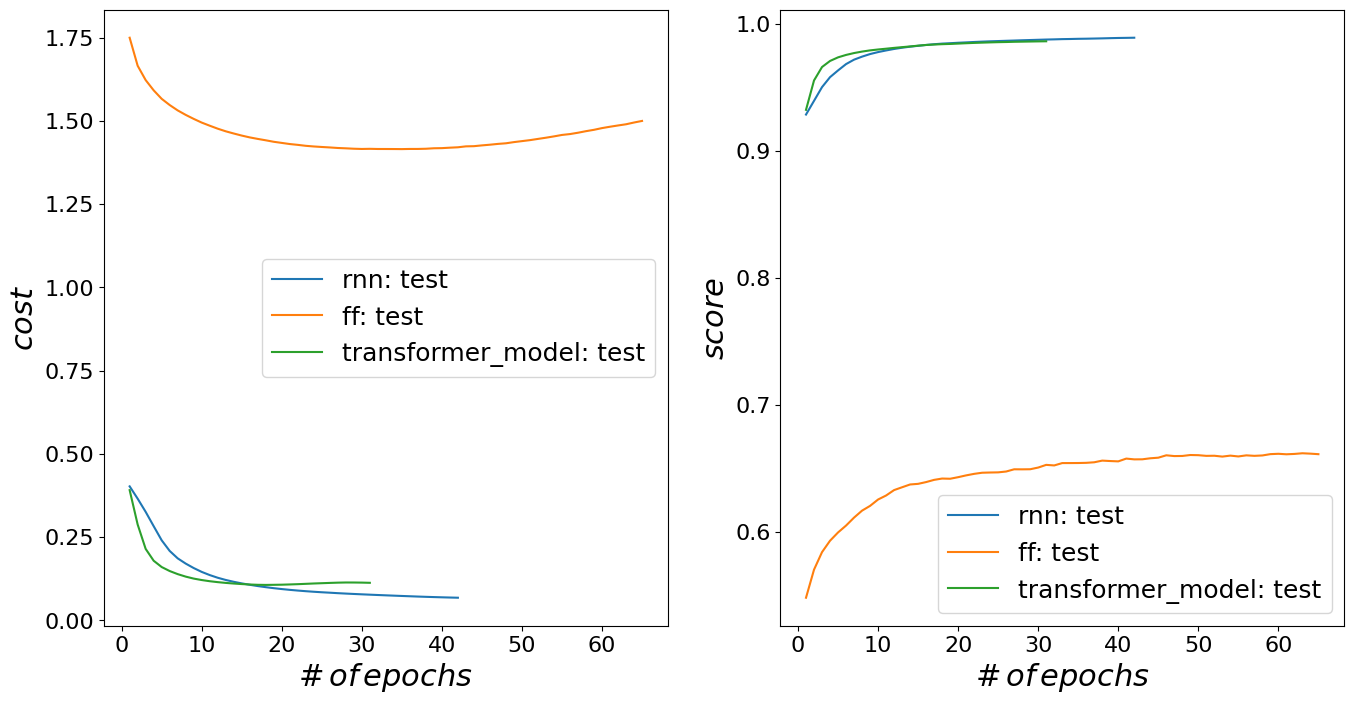

In [19]:
multiple_models_history_figure([rnn, ff, trf], ['test'])

# POS Tagging examples

In [20]:
def non_seq_tagger(sentence, model, pos_nonseq:NonSequentialDataset):
    window_embedings, listtag = pos_nonseq.window_word2vec_sentece(sentence)
    pr = model([window_embedings])[0]
    pr = pos_nonseq.get_numpy2tag(pr,onehot=True)
    not_none_cnt = 0
    for i in range(len(listtag)):
      if listtag[i][1] != None:
        print((listtag[i][0], pr[not_none_cnt]))
        not_none_cnt += 1
    print()

def seq_tagger(sentence, rnn_model, pos_seq:SequentialDataset):
  encode = pos_seq.sents_encode([sentence])
  encode = tf.cast(encode, tf.int32)
  pr = rnn_model.call([encode])[0].numpy().argmax(axis=-1) + 1
  pr = pos_seq.tag_decode(pr)
  for x, y in zip(sentence.split(), pr[0].split()):
    print((x, y))
  print()

In [21]:
print('Feed Forward POS Tagger \n{}'.format('='*23))

non_seq_tagger('we create a pos tagger and we are very happy for that !', ff, pos_nonseq)
non_seq_tagger('one duzine equals with twelve .', ff, pos_nonseq)

print('RNN POS Tagger \n{}'.format('='*14))

seq_tagger('we create a pos tagger and we are very happy for that !', rnn, pos_seq)
seq_tagger('one duzine equals with twelve .', rnn, pos_seq)

print('Transformer POS Tagger \n{}'.format('='*22))

seq_tagger('we create a pos tagger and we are very happy for that !', rnn, pos_seq)
seq_tagger('one duzine equals with twelve .', rnn, pos_seq)

Feed Forward POS Tagger 
('we', 'PRON')
('create', 'VERB')
('a', 'VERB')
('pos', 'VERB')
('tagger', 'PUNCT')
('and', 'PUNCT')
('we', 'PRON')
('are', 'AUX')
('very', 'AUX')
('happy', 'ADJ')
('for', 'VERB')
('that', 'ADP')
('!', 'PUNCT')

('one', 'PUNCT')
('duzine', 'NUM')
('equals', 'PUNCT')
('with', 'NUM')
('twelve', 'ADP')
('.', 'PUNCT')

RNN POS Tagger 
('we', 'PRON')
('create', 'VERB')
('a', 'DET')
('pos', 'NOUN')
('tagger', 'NOUN')
('and', 'CCONJ')
('we', 'PRON')
('are', 'AUX')
('very', 'ADV')
('happy', 'ADJ')
('for', 'ADP')
('that', 'PRON')
('!', 'PUNCT')

('one', 'NUM')
('duzine', 'VERB')
('equals', 'ADP')
('with', 'ADP')
('twelve', 'NUM')
('.', 'PUNCT')

Transformer POS Tagger 
('we', 'PRON')
('create', 'VERB')
('a', 'DET')
('pos', 'NOUN')
('tagger', 'NOUN')
('and', 'CCONJ')
('we', 'PRON')
('are', 'AUX')
('very', 'ADV')
('happy', 'ADJ')
('for', 'ADP')
('that', 'PRON')
('!', 'PUNCT')

('one', 'NUM')
('duzine', 'VERB')
('equals', 'ADP')
('with', 'ADP')
('twelve', 'NUM')
('.', 'PUN

# References
- UD_English-GUM Dataset: [https://github.com/UniversalDependencies/UD_English-GUM](https://github.com/UniversalDependencies/UD_English-GUM)
- GloVe: [https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)
- Slided Window POS Tagger: [https://www.dlsi.ua.es/~mlf/docum/sanchezvillamil04p.pdf](https://www.dlsi.ua.es/~mlf/docum/sanchezvillamil04p.pdf)
- Attention Is All You Need: [https://arxiv.org/abs/1706.03762](https://arxiv.org/abs/1706.03762)
